In [1]:
IHDP_100_TRAIN_URL = 'http://www.fredjo.com/files/ihdp_npci_1-100.train.npz'
IHDP_100_TEST_URL = 'http://www.fredjo.com/files/ihdp_npci_1-100.test.npz'
IHDP_1000_TRAIN_URL = 'http://www.fredjo.com/files/ihdp_npci_1-1000.train.npz.zip'
IHDP_1000_TEST_URL = 'http://www.fredjo.com/files/ihdp_npci_1-1000.test.npz.zip'

In [4]:
import numpy as np
import pandas as pd
from functools import partial
from itertools import combinations
from math import factorial
import torch
from torch.autograd import Variable
from types import FunctionType, MethodType
import warnings
import requests
import os
from urllib.parse import urlparse
import zipfile

In [5]:
def download_dataset(url, dataset_name, dataroot=None, filename=None):
    if dataroot is None:
        dataroot = DATA_FOLDER
    if filename is None:
        filename = os.path.basename(urlparse(url).path)
    file_path = os.path.join(dataroot, filename)
    if os.path.isfile(file_path):
        print('{} dataset already exists at {}'.format(dataset_name, file_path))
    else:
        print('Downloading {} dataset to {} ...'.format(dataset_name, file_path), end=' ')
        download_file(url, file_path)
        print('DONE')
    return file_path


def download_file(url, file_path):
    # open in binary mode
    with open(file_path, "wb") as f:
        # get request
        response = requests.get(url)
        # write to file
        f.write(response.content)


def unzip(path_to_zip_file, unzip_dir=None):
    unzip_path = os.path.splitext(path_to_zip_file)[0]
    if os.path.isfile(unzip_path):
        print('File already unzipped at', unzip_path)
        return unzip_path

    print('Unzipping {} to {} ...'.format(path_to_zip_file, unzip_path), end=' ')
    if unzip_dir is None:
        unzip_dir = os.path.dirname(path_to_zip_file)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print('DONE')
    return unzip_path


In [6]:
def load_ihdp(split='all', i=0, observe_counterfactuals=False, return_ites=False,
              return_ate=False, dataroot=None):
    """
    Load a single instance of the IHDP dataset
    :param split: 'train', 'test', or 'both' (the default IHDP split is 90/10)
    :param i: dataset instance (0 <= i < 1000)
    :param observe_counterfactuals: if True, return double-sized dataset with
        both y0 (first half) and y1 (second half) observed
    :param return_ites: if True, return ITEs
    :param return_ate: if True, return ATE
    :return: dictionary of results
    """
    if 0 <= i < 100:
        n_realizations = 100
    elif 100 <= i < 1000:
        n_realizations = 1000
        i = i - 100
    else:
        raise ValueError('Invalid i: {} ... Valid i: 0 <= i < 1000'.format(i))

    if split == 'all':
        train, test = load_ihdp_datasets(split=split, n_realizations=n_realizations,
                                         dataroot=dataroot)
    else:
        data = load_ihdp_datasets(split=split, n_realizations=n_realizations,
                                  dataroot=dataroot)

    ws = []
    ts = []
    ys = []
    ys_cf = []
    itess = []
    datasets = [train.f, test.f] if split == 'all' else [data.f]
    for dataset in datasets:
        w = dataset.x[:, :, i]
        t = dataset.t[:, i]
        y = dataset.yf[:, i]
        y_cf = dataset.ycf[:, i]
        ites = dataset.mu1[:, i] - dataset.mu0[:, i]

        ws.append(w)
        ts.append(t)
        ys.append(y)
        ys_cf.append(y_cf)
        itess.append(ites)

    w = np.vstack(ws)
    t = np.concatenate(ts)
    y = np.concatenate(ys)
    y_cf = np.concatenate(ys_cf)
    ites = np.concatenate(itess)
    ate = np.mean(ites)

    d = {}
    if observe_counterfactuals:
        d['w'] = np.vstack([w, w.copy()])
        d['t'] = np.concatenate([t, np.logical_not(t.copy()).astype(int)])
        d['y'] = np.concatenate([y, y_cf])
        ites = np.concatenate([ites, ites.copy()])  # comment if you don't want duplicates
    else:
        d['w'] = w
        d['t'] = t
        d['y'] = y

    if return_ites:
        d['ites'] = ites
    if return_ate:
        d['ate'] = ate

    return d

In [7]:
def load_ihdp_datasets(split='train', n_realizations=100, dataroot=None):
    """
    Load the IHDP data with the nonlinear response surface ("B") that was used
    by Shalit et al. (2017). Description of variables:
        x: covariates (25: 6 continuous and 19 binary)
        t: treatment (binary)
        yf: "factual" (observed) outcome
        ycf: "counterfactual" outcome (random)
        mu0: noiseless potential outcome under control
        mu1: noiseless potential outcome under treatment
        ate: I guess just what was reported in the Hill (2011) paper...
            Not actually accurate. The actual SATEs for the data are the
            following (using (mu1 - mu0).mean()):
                train100:   4.54328871735309
                test100:    4.269906127209613
                all100:     4.406597422281352
                train1000:  4.402550421661204
                test1000:   4.374712690625632
                all1000:    4.388631556143418
        yadd: ???
        ymul: ???
    :param split: 'train', 'test', or 'both'
    :param n_realizations: 100 or 1000 (the two options that the data source provides)
    :return: NpzFile with all the data ndarrays in the 'f' attribute
    """
    if split.lower() not in SPLIT_OPTIONS:
        raise ValueError('Invalid "split" option {} ... valid options: {}'
                         .format(split, SPLIT_OPTIONS))
    if isinstance(n_realizations, str):
        n_realizations = int(n_realizations)
    if n_realizations not in N_REALIZATIONS_OPTIONS:
        raise ValueError('Invalid "n_realizations" option {} ... valid options: {}'
                         .format(n_realizations, N_REALIZATIONS_OPTIONS))
    if n_realizations == 100:
        if split == 'train' or split == 'all':
            path = download_dataset(IHDP_100_TRAIN_URL, 'IHDP train 100', dataroot=dataroot)
            train = np.load(path)
        if split == 'test' or split == 'all':
            path = download_dataset(IHDP_100_TEST_URL, 'IHDP test 100', dataroot=dataroot)
            test = np.load(path)
    elif n_realizations == 1000:
        if split == 'train' or split == 'all':
            path = download_dataset(IHDP_1000_TRAIN_URL, 'IHDP train 1000', dataroot=dataroot)
            unzip_path = unzip(path)
            train = np.load(unzip_path)
        if split == 'test' or split == 'all':
            path = download_dataset(IHDP_1000_TEST_URL, 'IHDP test 1000', dataroot=dataroot)
            unzip_path = unzip(path)
            test = np.load(unzip_path)

    if split == 'train':
        return train
    elif split == 'test':
        return test
    elif split == 'all':
        return train, test

In [13]:
SPLIT_OPTIONS = {'train', 'test', 'all'}
N_REALIZATIONS_OPTIONS = {100, 1000}
train, test = load_ihdp_datasets(split='all', n_realizations=100, dataroot='./hdpi')

IHDP train 100 dataset already exists at ./hdpi/ihdp_npci_1-100.train.npz


In [11]:
! mkdir hdpi

In [14]:
train_1000, test_1000 = load_ihdp_datasets(split='all', n_realizations=1000, dataroot='./hdpi')

Unzipping ./hdpi/ihdp_npci_1-1000.train.npz.zip to ./hdpi/ihdp_npci_1-1000.train.npz ... DONE
Unzipping ./hdpi/ihdp_npci_1-1000.test.npz.zip to ./hdpi/ihdp_npci_1-1000.test.npz ... DONE


In [15]:
train

In [17]:
train.files

['ate', 'mu1', 'mu0', 'yadd', 'yf', 'ycf', 't', 'x', 'ymul']

In [61]:
train['x'].shape

(672, 25, 100)

In [ ]:
train['x']

In [36]:
train['yf'].shape

(672, 100)

In [34]:
train['t'].shape


(672, 100)

In [60]:
train['t']

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [35]:
test['t'].shape


(75, 100)

In [39]:
train['mu1'].shape

(672, 100)

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

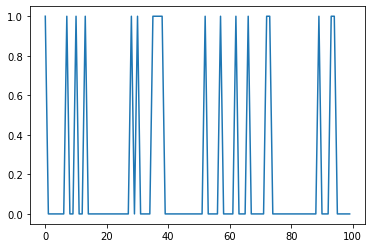

In [43]:
plt.plot(test['t'][0])

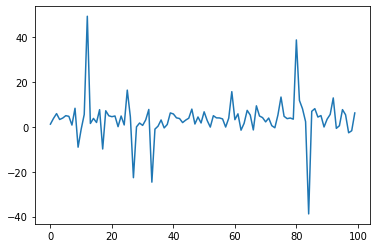

In [47]:
plt.plot(test['mu1'][0]-test['yf'][0])

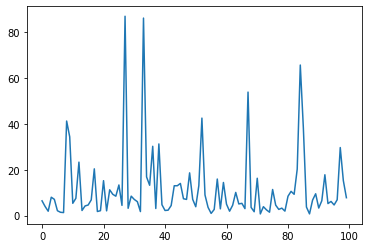

In [50]:
plt.plot(test['mu0'][0])

In [51]:
train['x'].shape

(672, 25, 100)

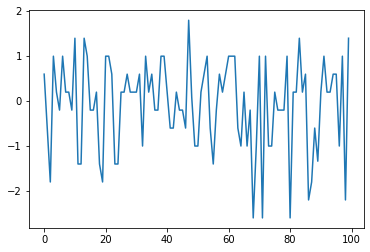

In [57]:
plt.plot(test['x'][0,1,:])

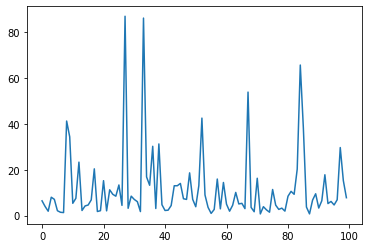

In [54]:
plt.plot(test['mu0'][0])

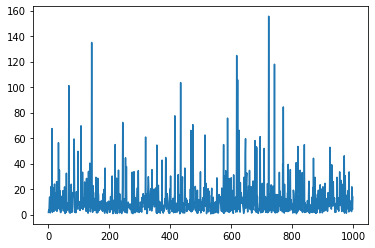

In [58]:
plt.plot(test_1000['mu0'][0])

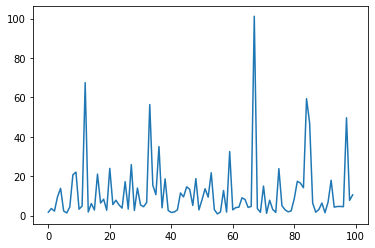

In [59]:
plt.plot(test_1000['mu0'][0][:100])